In [1]:
pwd

'C:\\Users\\Seif\\Desktop\\Ezz\\Semester 10 (Running)\\Material\\Machine Learning\\Assignments\\Assignment 3'

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
complete = pd.read_csv ("house_data_complete.csv")

In [4]:
complete = complete.dropna()

In [5]:
complete = complete.sample(frac=1, replace=False)
complete

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
18419,5347200165,20141002T000000,265000.0,3,1.00,1070,4800,1.0,0,0,...,6,970,100,1947,0,98126,47.5187,-122.377,1120,1198
21049,8956200770,20140723T000000,549950.0,4,3.50,3906,9674,2.0,0,2,...,9,3906,0,2014,0,98001,47.2931,-122.264,2673,6500
12454,6450304630,20141201T000000,229000.0,2,1.00,810,5100,1.0,0,0,...,6,810,0,1955,0,98133,47.7317,-122.343,1500,5100
13141,7504001320,20141121T000000,570000.0,3,2.50,2420,11953,1.0,0,0,...,9,2420,0,1990,0,98074,47.6285,-122.054,2420,12215
16749,8944460190,20150225T000000,425000.0,4,2.50,2689,6688,2.0,0,0,...,9,2689,0,2006,0,98030,47.3803,-122.184,2665,5700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20142,8029770470,20140605T000000,550000.0,4,2.50,2700,5150,2.0,0,0,...,9,2700,0,2007,0,98059,47.5071,-122.148,3160,7620
1172,8956000350,20140903T000000,605000.0,3,2.50,2010,3667,2.0,0,0,...,9,2010,0,2008,0,98027,47.5450,-122.015,2350,3600
18039,2571910100,20141029T000000,344000.0,4,2.50,2100,8501,2.0,0,0,...,7,2100,0,1993,0,98022,47.1951,-122.010,2130,8560
18679,9264920870,20141023T000000,300000.0,3,2.25,1730,10030,1.0,0,0,...,8,1730,0,1985,0,98023,47.3108,-122.345,2090,8823


In [6]:
complete = complete.drop(['id','zipcode','long','lat','date'],1)

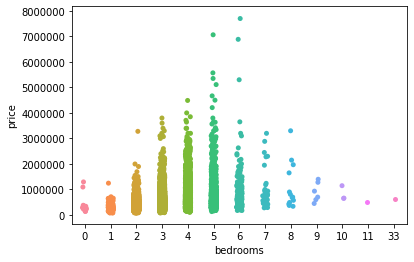

In [7]:
sns.stripplot(x='bedrooms', y='price',data=complete)

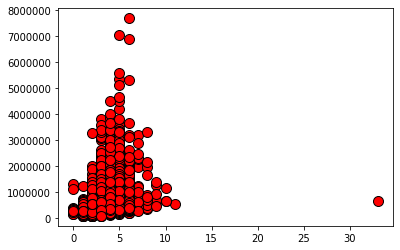

In [8]:
xplot =  complete['bedrooms']  
yplot = complete['price']
plt.plot(xplot, yplot, 'ro', ms=10, mec='k')

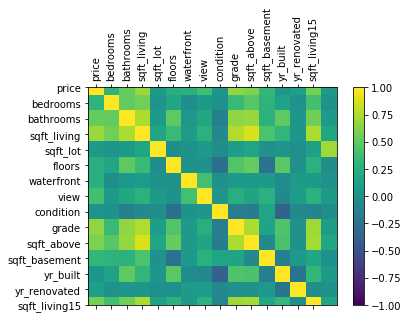

In [9]:
names=['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated','sqft_living15','sqft_lot15']
df=complete[names]
correlations= df.corr()
fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(correlations,vmin=-1,vmax=1)
fig.colorbar(cax)
ticks=np.arange(0,15,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.xticks(rotation=90)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [10]:
y = complete['price']
x = complete.drop(['price'],1)

In [11]:
x = ( ( x - x.mean() ) / x.std() )
size = x.shape[0]

In [12]:
length1 = round((60/100) * size)
length2 = round((20/100) * size)
training = complete[:length1]
y0 = training['price']
x0 = training.drop(['price'],1)
firstindex = length1 + 1
lastindex = firstindex + length2 
validation = complete[ firstindex : lastindex]
y1 = validation['price']
x1 = validation.drop(['price'],1)
testing = complete[lastindex + 1 :]
y2 = testing['price']
x2 = testing.drop(['price'],1)

In [13]:
x0 = ( ( x0 - x0.mean() ) / x0.std() )
x1 = ( ( x1 - x1.mean() ) / x1.std() )
x2 = ( ( x2 - x2.mean() ) / x2.std() )

In [14]:
#Linear Regression first hypothesis
m0 = y0.size
m1 = y1.size
m2 = y2.size
x0 = np.concatenate([np.ones((m0, 1)), x0], axis=1)
x1 = np.concatenate([np.ones((m1, 1)), x1], axis=1)
x2 = np.concatenate([np.ones((m2, 1)), x2], axis=1)

In [15]:
def computeCost(x,y,theta,lumda):
    J = 0
    m = y.size
    H = np.dot(x,theta)
    J = (1/(2*m))* sum((H - y) ** 2)
    J = J + ( (lumda/(2*m)) * sum(theta**2) )
    return J

In [16]:
def gradientDescent(x, y, theta, alpha, num_iters,lumda):
    m = y.size
    J_history = []
    alphabym=alpha/m
    for i in range(num_iters):
        H=np.dot(x,theta)
        theta[0] = theta[0] - ( alphabym * sum( H - y ) )
        theta[1:] = ( theta[1:] * (1-((alpha*lumda)/m)) ) - ( (alpha/m)* np.dot(x[:,1:].T,H-y) )
        # save the cost J in every iteration
        J_history.append(computeCost(x,y,theta,lumda))
    return theta, J_history        

Text(0, 0.5, 'Cost J')

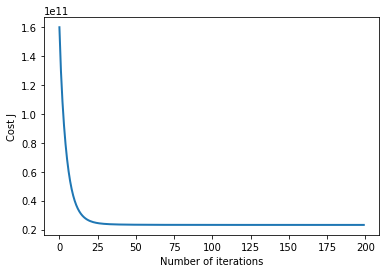

In [17]:
# Training hyp1
theta = np.zeros(16)
iterations = 200
alpha = 0.1
lumda = 0.01
theta, J_history = gradientDescent(x0 ,y0,theta,alpha,iterations,lumda)
# plot Training hyp1
plt.plot(np.arange(len(J_history)), J_history, lw=2)
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')

In [18]:
# best lumda in hypothesis 1
Arrlum = np.array([0.01,0.1,1,2])
thetas = np.zeros((Arrlum.size,16))
iterations = 200
alpha = 0.1
for i in range(Arrlum.size):
    lumdacurrent = Arrlum[i]
    thetas[i], J_history= gradientDescent(x0 ,y0,thetas[i],alpha,iterations,lumdacurrent)
Error = []    
for i in range(thetas.shape[0]):
    thetacurr = thetas[i]
    Hcurr = np.dot(x1,thetacurr) # x of validation times theta to be chosen
    Errorcurr = sum((Hcurr - y1)**2 / x1.shape[0])
    Error.append(Errorcurr)
print(Error)
index = np.argmin(Error)
print(index)
Arrlum[index]

[46062205285.04194, 46062208582.25772, 46062242015.7752, 46062280147.1198]
0


0.01

In [19]:
# Calculating the Error of hyp 1 on train validation and testing
Hyptrain = np.dot(x0,theta)
trainerror = sum( (Hyptrain - y0)**2 / x0.shape[0])
print(trainerror)
Hypval = np.dot(x1,theta)
valerror = sum( (Hypval - y1)**2 / x1.shape[0] )
print(valerror)
Hyptest = np.dot(x2,theta)
testerror = sum( (Hyptest - y2) **2 / x2.shape[0])
print(testerror)

46428125462.01137
46062205285.04194
48230174945.2866


Text(0, 0.5, 'Cost J')

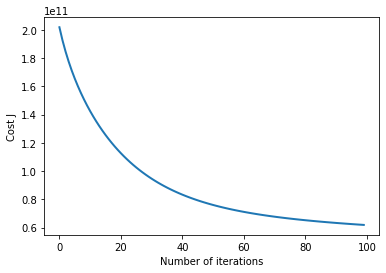

In [20]:
# Training hyp2
theta2 = np.zeros(16)
iterations = 100
alpha = 0.001
lumda = 0.01
theta2, J_history2 = gradientDescent(x0**2 ,y0,theta2,alpha,iterations,lumda)
# plot Training hyp2
plt.plot(np.arange(len(J_history2)), J_history2, lw=2)
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')

In [21]:
# Calculating the Error of hyp 1 on train validation and testing
Hyptrain = np.dot(x0**2,theta2)
trainerror = sum( (Hyptrain - y0)**2 / x0.shape[0])
print(trainerror)
Hypval = np.dot(x1**2,theta2)
valerror = sum( (Hypval - y1)**2 / x1.shape[0] )
print(valerror)
Hyptest = np.dot(x2**2,theta2)
testerror = sum( (Hyptest - y2) **2 / x2.shape[0])
print(testerror)

123841042108.83008
110319027302.1841
187664471363.45477


Text(0, 0.5, 'Cost J')

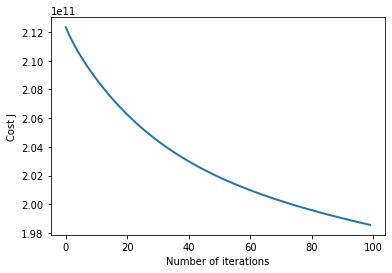

In [22]:
# Training hyp3
theta3 = np.zeros(16)
iterations = 100
alpha = 0.000001
lumda = 0.01
theta3, J_history3 = gradientDescent(x0**3 ,y0,theta3,alpha,iterations,lumda)
# plot Training hyp3
plt.plot(np.arange(len(J_history3)), J_history3, lw=2)
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')

In [23]:
# Calculating the Error of hyp 1 on train validation and testing
Hyptrain = np.dot(x0**3,theta3)
trainerror = sum( (Hyptrain - y0)**2 / x0.shape[0])
print(trainerror)
Hypval = np.dot(x1**3,theta3)
valerror = sum( (Hypval - y1)**2 / x1.shape[0] )
print(valerror)
Hyptest = np.dot(x2**3,theta3)
testerror = sum( (Hyptest - y2) **2 / x2.shape[0])
print(testerror)

397116928928.91785
385527007671.4886
404009734344.0364
